In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import floor, ceil
import keras.models
from keras.layers.convolutional import Conv1D, ZeroPadding1D
from keras.layers.recurrent import Recurrent, LSTM, GRU
from keras.layers.pooling import MaxPooling1D, AveragePooling1D
from keras.utils import plot_model, np_utils
import keras.backend as K
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score
% matplotlib inline

# preprocess

In [42]:
PAD_WITH_DERIV = True
def pad_with_deriv(x_train):
    x_deriv = np.zeros(x_train.shape)
    x_deriv[:,:-1,:] = np.diff(x_train,axis=1)
    x_train_2 = np.zeros((x_train.shape[0],x_train.shape[1],2))
    x_train_2[:,:,0] = x_train[:,:,0]
    x_train_2[:,:,1] = x_deriv[:,:,0]
    return x_train_2

def load_and_format_data():
    # load data
    x_train = np.array([])
    y_train = np.array([])
    for i in ['7']:
        dataset = 'train/'+str(i)
        x_data = pd.read_csv(dataset + '.train.calcium.csv')
        y_data = pd.read_csv(dataset + '.train.spikes.csv')    
        for key in x_data:
            x_train = np.concatenate((x_train,x_data[key].dropna()))
            y_train = np.concatenate((y_train,y_data[key].dropna()))
    x_test = pd.read_csv('train/10' + '.train.calcium.csv')['9'].dropna()
    y_test = pd.read_csv('train/10' + '.train.spikes.csv')['9'].dropna()
    num_y = int(np.max(y_train+1))
    # binarize labels
    lb = LabelBinarizer()
    lb.fit(y_train) # this lb takes 0 -> [1,0,0,0,0], 1-> [0,1,0,0,0], etc.
    y_train_orig = y_train
    y_train = lb.transform(y_train)
#     y_test = lb.transform(y_test)
    # reshape data
    x_train = x_train.reshape((1, len(x_train), 1))
    y_train = y_train.reshape((1, len(y_train), y_train.shape[1]))
    x_test = x_test.values.reshape((1, len(x_test), 1))
#     y_test = y_test.reshape((1, len(y_test), y_test.shape[1]))
    if PAD_WITH_DERIV:
        x_train = pad_with_deriv(x_train)
        x_test = pad_with_deriv(x_test)
    return x_train, y_train, x_test, y_test, y_train_orig, num_y
x_train, y_train, x_test, y_test, y_train_orig, num_y = load_and_format_data()
print("train, test sizes",x_train.shape,x_test.shape)

train, test sizes (1, 884682, 2) (1, 9698, 2)


In [43]:
# gives Nonetype error which means gradient is 0
def custom_loss(y_true, y_pred):
    y_true_k = K.clip(y_true,0,1)
    print("calling...",y_true,y_true_k,y_pred)
#     loss = K.switch(K.equal(y_true,-1),0,K.square(y_true-y_pred))
    return -1*K.sum(y_pred * y_true)

def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

def pos_acc(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    return tp/(tp+fn)

def neg_acc(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    return tn/(tn+fp)


# create model

In [49]:
sample_weight = np.ones((1,len(y_train_orig)))
sample_weight[0,y_train_orig==0]=1/10000
kernel_sizes = [5,13,31] # should be odd
pad_sizes = [floor(s/2) for s in kernel_sizes]
model = keras.models.Sequential()
model.add(ZeroPadding1D(padding=pad_sizes[0], input_shape=(None, x_train.shape[-1])))
model.add(Conv1D(filters=num_y, kernel_size=kernel_sizes[0], activation="linear"))
model.add(MaxPooling1D(pool_size=2,strides=1,padding="same"))
model.add(ZeroPadding1D(padding=pad_sizes[1], input_shape=(None, x_train.shape[-1])))
model.add(Conv1D(filters=num_y, kernel_size=kernel_sizes[1], activation="linear"))
model.add(ZeroPadding1D(padding=pad_sizes[2], input_shape=(None, x_train.shape[-1])))
model.add(Conv1D(filters=num_y, kernel_size=kernel_sizes[2], activation="softmax"))
model.compile(loss='mse', optimizer='adam', metrics=['accuracy',pos_acc,neg_acc],
              sample_weight=sample_weight, sample_weight_mode="temporal")

# fit the model

In [50]:
epochs = 10
model.fit(x_train, y_train, epochs=epochs, verbose=1)

Epoch 1/10
1/1 [==============================] - 1s - loss: 0.1876 - acc: 0.1031 - pos_acc: 4.7362e-04 - neg_acc: 0.9978
Epoch 2/10
1/1 [==============================] - 1s - loss: 0.1796 - acc: 0.4215 - pos_acc: 0.0040 - neg_acc: 0.9995
Epoch 3/10
1/1 [==============================] - 1s - loss: 0.1731 - acc: 0.7497 - pos_acc: 0.0098 - neg_acc: 0.9998
Epoch 4/10
1/1 [==============================] - 1s - loss: 0.1665 - acc: 0.8985 - pos_acc: 0.0188 - neg_acc: 0.9996
Epoch 5/10
1/1 [==============================] - 1s - loss: 0.1597 - acc: 0.9504 - pos_acc: 0.0303 - neg_acc: 0.9995
Epoch 6/10
1/1 [==============================] - 1s - loss: 0.1521 - acc: 0.9700 - pos_acc: 0.0451 - neg_acc: 0.9993
Epoch 7/10
1/1 [==============================] - 1s - loss: 0.1442 - acc: 0.9780 - pos_acc: 0.0625 - neg_acc: 0.9991
Epoch 8/10
1/1 [==============================] - 1s - loss: 0.1361 - acc: 0.9818 - pos_acc: 0.0841 - neg_acc: 0.9990
Epoch 9/10
1/1 [==============================] - 1s

# evaluate

----------training----------
pred nonzeros	 0.0168953364034
acc		 0.986559012165
corr		 -0.00610385745314
----------testing----------
pred nonzeros	 0.0179418436791
acc		 0.962878944112
corr		 -0.0150716313693


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:5: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


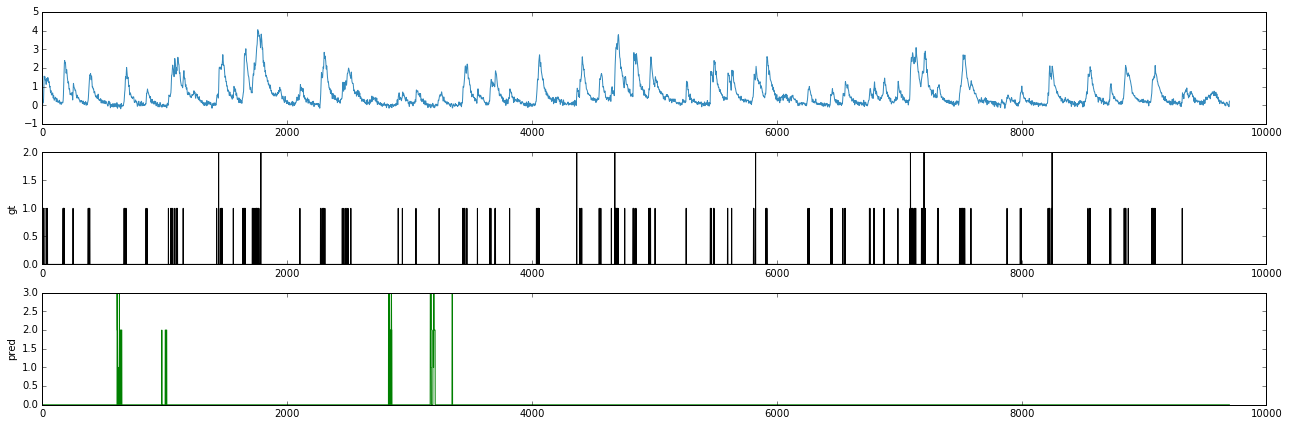

In [51]:
def visualize(calcium, spikes, spikes2=None):
    plt.figure(figsize=(18, 6))
    t = np.arange(len(calcium))
    plt.hold(True)
    if spikes2==None:
        plt.subplot(211)
        plt.plot(t, calcium, color='#348ABD')
        plt.subplot(212)
        plt.plot(t, spikes, color='black',label='gt')
    else:
        plt.subplot(311)
        plt.plot(t, calcium, color='#348ABD')
        plt.subplot(312)
        plt.plot(t, spikes, color='black',label='gt')
        plt.ylabel('gt')
        plt.subplot(313)
        plt.plot(t, spikes2, color='g',label='pred')
        plt.ylabel('pred')
#     plt.ylim([-6, 3])
    plt.xlim([0,10000])
    plt.tight_layout()
    plt.show()
    
def corr(gt, pred):
    return np.corrcoef(gt,pred)[0,1]

print('----------training----------')
y_pred_train = np.argmax(model.predict(x_train)[0,:,:],axis=1)
print('pred nonzeros\t',str(np.sum(y_pred_train) / y_pred_train.size))
print("acc\t\t",accuracy_score(y_pred_train,y_train_orig))
print("corr\t\t",corr(y_pred_train,np.argmax(y_train[0,:,:],axis=1)))

print('----------testing----------')
y_pred = np.argmax(model.predict(x_test)[0,:,:],axis=1)
print('pred nonzeros\t',str(np.sum(y_pred) / y_pred.size))
print("acc\t\t",accuracy_score(y_pred,y_test))
print("corr\t\t",corr(y_pred,y_test))
# visualize(x_train[0,:,0],y_train_orig,y_pred_train)
visualize(x_test[0,:,0],y_test,y_pred)